# Agent-Based Model on Cat Behavior

### In our project we decided to create 4 total cats with several different traits ranging from hunger levels to personality traits
### Based on the traits each cat has will determine their interactions with each other, objects in the room, and people who walk in the room

In [2]:
from IPython.display import HTML
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time

To start here is a legend of all potential personality traits and needs our cats may have.

In [90]:
legend= {'Calm' : 'Very relaxed; Gets along with all cats',
         'Shy' : 'Takes a while to warm up, might hide away; Does not interact with other cats' ,
         "Playful" : 'Wants to hunt and play; Gets along with Calm cats, Fights with Aggressive cats' ,
         'Aggressive' : 'Will hiss, growl, and bite; Fights with all cats' ,

         'Affectionate' : 'Loves cuddles; Gets along with and seeks out humans ' } 


#
# Trait	Behavior Around Others
# Shy ≥ 2	Avoids other cats — moves away if another cat is nearby
# Aggressive ≥ 2	Approaches other cats — initiates "conflict" when nearby
# Calm ≥ 2	Doesn't react to other cats (neutral)
# Playful ≥ 2	Moves toward cats (seeks interaction), unless the other cat is aggressive

Because we want our interactions to be as random and organic as possible we will create a class that will help cat decisions!

In [94]:
import random

class Cat:
    def __init__(self, name, personality, image_path):
        self.name = name
        self.personality = personality  # Should only include 'Playful', 'Aggressive', 'Shy', 'Calm'
        self.image_path = image_path
        self.activity = 'still'
        self.mood = "😐"

        # Physical needs start fulfilled
        self.hunger = 0  # 0 = full
        self.sleep = 0   # 0 = rested
        self.potty = 0   # 0 = no urge

        # Positioning
        self.x, self.y = 15, 137  # Start at bed
        self.speed = 0.8
        self.target = (self.x, self.y)

    def random_target(self):
        return (random.randint(10, 140), random.randint(10, 140))

    def update_traits(self):
        self.hunger += 1
        self.sleep += 1
        self.potty += 1

    def eat(self):
        self.hunger = 0
        self.potty += 2
        self.activity = "eat"
        self.target = (15, 12)  # food bowl

    def sleep_action(self):
        self.sleep = max(0, self.sleep - 3)
        self.activity = "sleep"
        self.target = (15, 137)  # bed

    def bathroom(self):
        self.potty = 0
        self.activity = "bathroom"
        self.target = (140, 137)  # litter

    def play(self):
        self.hunger += 2
        self.sleep += 2
        self.potty += 1
        self.activity = "play"
        self.target = (140, 12)  # play tree

    def action_choices(self):
        actions = {
            'eat': self.hunger,
            'sleep_action': self.sleep,
            'bathroom': self.potty,
            'play': self.personality.get('Playful', 0)
        }
        chosen = max(actions, key=actions.get)
        getattr(self, chosen)()

    def move(self):
        dx = self.target[0] - self.x
        dy = self.target[1] - self.y
        dist = (dx ** 2 + dy ** 2) ** 0.5
        if dist > 1:
            self.x += self.speed * dx / dist
            self.y += self.speed * dy / dist
            self.x = min(max(self.x, 0), 150)
            self.y = min(max(self.y, 0), 150)

    def roam(self):
        if self.mood == "😐":
            self.target = self.random_target()

    def distance_to(self, other):
        return ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5

    def interact_with(self, other_cat):
        if self == other_cat:
            return  # don't interact with self
    
        distance = self.distance_to(other_cat)
        if distance < 25:
            # SHY cats avoid everyone
            if self.personality.get("Shy", 0) >= 2:
                self.mood = "🙀"
                dx = self.x - other_cat.x
                dy = self.y - other_cat.y
                self.target = (self.x + dx, self.y + dy)
    
            # AGGRESSIVE cats approach and "initiate conflict"
            elif self.personality.get("Aggressive", 0) >= 2:
                self.mood = "😾"
                self.target = (other_cat.x, other_cat.y)
    
            # PLAYFUL cats seek others unless the other is aggressive
            elif self.personality.get("Playful", 0) >= 2:
                if other_cat.personality.get("Aggressive", 0) >= 2:
                    self.mood = "😿"  # avoid aggressive cats
                    dx = self.x - other_cat.x
                    dy = self.y - other_cat.y
                    self.target = (self.x + dx, self.y + dy)
                else:
                    self.mood = "😺"
                    self.target = (other_cat.x, other_cat.y)
    
            # CALM cats are neutral
            elif self.personality.get("Calm", 0) >= 2:
                self.mood = "😌"
    
        else:
            self.mood = "😐"

    def __repr__(self):
        return f'Cat({self.name}, {self.personality})'


In [96]:
cats = [
    Cat('Tito', {
        'Playful': 2,
        'Shy': 1,
        'Calm': 1,
        'Aggressive': 1
    }, "tito.png"),

    Cat('Tobi', {
        'Playful': 1,
        'Shy': 2,
        'Calm': 1,
        'Aggressive': 1
    }, "tobi.png"),

    Cat('Dumpling', {
        'Playful': 1,
        'Shy': 1,
        'Calm': 2,
        'Aggressive': 1
    }, "dumpling.png"),

    Cat('Jiji', {
        'Playful': 1,
        'Shy': 1,
        'Calm': 1,
        'Aggressive': 2
    }, "jiji.png")
]


Here you can find out who our cats are and what their personality traits are!

The start of the simulation for the visualization.

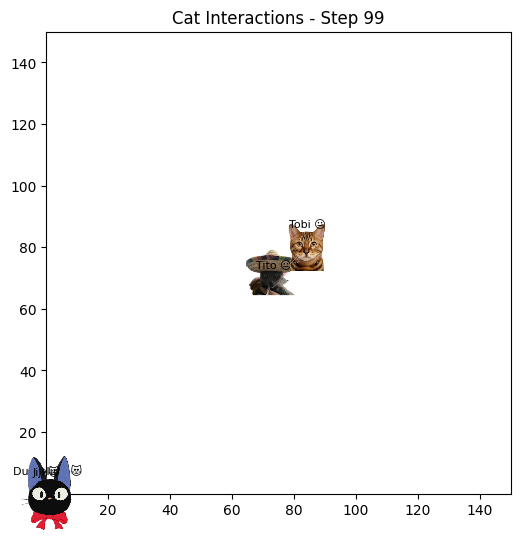

In [18]:
from IPython.display import display, clear_output
def imscatter(x, y, image_path, ax=None, zoom=0.25):
    if ax is None:
        ax = plt.gca()
    image = Image.open(image_path).convert("RGBA")
    image = np.asarray(image)
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)
    return ab
    
#Visualization
fig, ax = plt.subplots(figsize=(6, 6))

for step in range(100):
    ax.clear()
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    ax.set_title(f"Cat Interactions - Step {step}")

    for i in range(len(cats)):
        for j in range(i + 1, len(cats)):
            cats[i].interact_with(cats[j])
            cats[j].interact_with(cats[i])  # mutual!
    
    # Now move + roam based on updated moods
    for cat in cats:
        if cat.mood == "😐":
            cat.roam()
        cat.move()

        imscatter(cat.x, cat.y, cat.image_path, ax=ax, zoom=0.25)
        ax.text(cat.x, cat.y + 6, f"{cat.name} {cat.mood}", ha='center', fontsize=8)

    for i in range(len(cats)):
        for j in range(i + 1, len(cats)):
            if cats[i].distance_to(cats[j]) < 30:
                ax.plot([cats[i].x, cats[j].x], [cats[i].y, cats[j].y], 'r--', alpha=0.3)
    plt.draw()
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1)
    
plt.close()


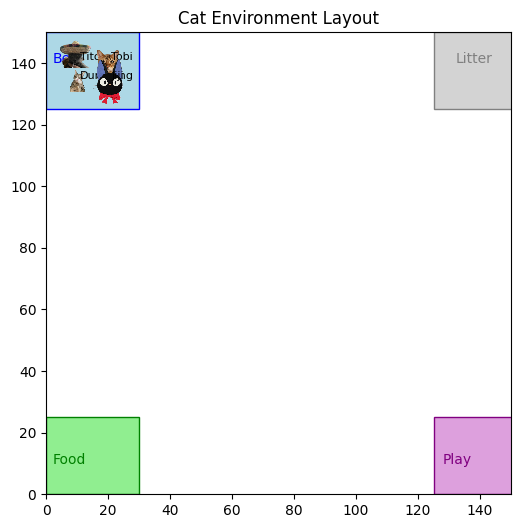

In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Load image function
def get_cat_image(path, zoom=0.15):
    return OffsetImage(mpimg.imread(path), zoom=zoom)

# Bed center coordinates
bed_center = (15, 137)

# Define cat names and images
cat_data = [
    ("Tito", "tito.png"),
    ("Tobi", "tobi.png"),
    ("Dumpling", "dumpling.png"),
    ("Jiji", "jiji.png")
]

# Define smart offsets so cats don’t overlap
offsets = [(-5, 3), (5, 3), (-5, -3), (5, -3)]

# Setup plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 150)
ax.set_ylim(0, 150)
ax.set_title("Cat Environment Layout")

# Add zones
ax.add_patch(patches.Rectangle((0, 125), 30, 25, edgecolor='blue', facecolor='lightblue'))
ax.text(2, 140, "Bed", fontsize=10, color='blue')

ax.add_patch(patches.Rectangle((125, 125), 30, 25, edgecolor='gray', facecolor='lightgray'))
ax.text(132, 140, "Litter", fontsize=10, color='gray')

ax.add_patch(patches.Rectangle((0, 0), 30, 25, edgecolor='green', facecolor='lightgreen'))
ax.text(2, 10, "Food", fontsize=10, color='green')

ax.add_patch(patches.Rectangle((125, 0), 30, 25, edgecolor='purple', facecolor='plum'))
ax.text(128, 10, "Play", fontsize=10, color='purple')

# Add each cat slightly offset from bed center
for (name, img_file), (dx, dy) in zip(cat_data, offsets):
    img = get_cat_image(f"{img_file}")
    ab = AnnotationBbox(img, (bed_center[0] + dx, bed_center[1] + dy), frameon=False)
    ax.add_artist(ab)
    ax.text(bed_center[0] + dx + 1, bed_center[1] + dy + 1, name, fontsize=8)

plt.show()
